# Optimal pipe insulation problem
The possible existence of an optimum insulation thickness for radial systems is suggested by the
presence of competing effects associated with an increase in this thickness. In particular,
although the conduction resistance increases with the addition of insulation, the convection
resistance decreases due to increasing outer surface area. Hence there may exist an insulation
thickness that minimizes heat loss by maximizing the total resistance to heat transfer. Resolve
this issue by considering the following system.

A thin-walled copper tube of radius $r_i$ is used to transport a low-temperature refrigerant and is
at a temperature $T_i$ that is less than that of the ambient air at $T_\mathrm{surr}$ around the
tube. Find the optimal thickness of insulation given:

- $r_i$ = 10 mm
- $k_\mathrm{insulation}$ = 0.055 W/mK
- $h_\mathrm{surr}$ = 5 W/m<sup>2</sup>K

### Known

In [1]:
inner_radius = 0.01 / 2 # m


### Find
The optimal insulation thickness for the pipe.
### Schematic
![Schematic](../images/1DPipeInsulationExample.png)
### Assumption
1. Steady state
2. One-dimemsional heat transfer in the radial direction.
3. Thermal resistance of the pipe wall is negligible
4. All properties are uniform and constant.
5. Radiation is negligible.
### Properties

In [2]:
thermal_conductivity_insulation = 0.055 # W/mK
convection_coefficient_surrounding = 5 # W/m2K

### Analysis
From the assumption, we can simplify our heat circuit as
![Heat circuit](../images/1DPipeInsulationExample_heat_circuit.png)
The total thermal resistance per unit length is then
$$R'_\mathrm{tot} = \frac{\ln(r/r_i)}{2\pi k_\mathrm{insulation}} + \frac{1}{2 \pi r h_\mathrm{surr}}$$
We can create a python function for this expression. 

In [3]:
import numpy as np
from typing import Union

def get_thermal_resistance_conduction_cylinder(
        wall_thickness: Union[float, np.ndarray],
        inner_radius: Union[float, np.ndarray],
        thermal_conductivity: Union[float, np.ndarray],
        length: Union[float, np.ndarray]
) -> Union[float, np.ndarray]:
    """Returns 1D thermal resistance in radial direction of a cylinder"""
    outer_radius = inner_radius + wall_thickness
    return np.log(outer_radius / inner_radius) / (2 * np.pi * thermal_conductivity * length)

def get_thermal_resistance_convenction_cylinder(
        radius: Union[float, np.ndarray],
        convection_coefficient: Union[float, np.ndarray],
        length: Union[float, np.ndarray]
) -> Union[float, np.ndarray]:
    outer_area = 2 * np.pi * radius * length
    return 1 / (convection_coefficient * outer_area)

def get_total_thermal_resistance_cylinder(
    wall_thickness: Union[float, np.ndarray],
    inner_radius: Union[float, np.ndarray],
    thermal_conductivity: Union[float, np.ndarray],
    convection_coefficient: Union[float, np.ndarray],
    length: Union[float, np.ndarray]
) -> Union[float, np.ndarray]:
    """Returns total thermal resistance"""
    resistance_conduction = get_thermal_resistance_conduction_cylinder(
        inner_radius=inner_radius,
        wall_thickness=wall_thickness,
        thermal_conductivity=thermal_conductivity,
        length=length
    )
    resistance_convection = get_thermal_resistance_convenction_cylinder(
        radius=inner_radius + wall_thickness,
        convection_coefficient=convection_coefficient,
        length=length
    )
    return resistance_conduction + resistance_convection

We can visually confirm that there is a optimal thickness.

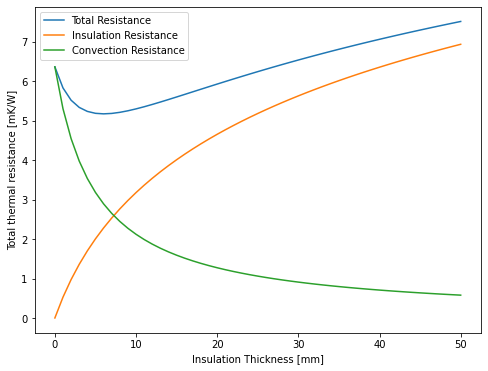

In [4]:
import matplotlib.pyplot as plt

thickness_vector = np.arange(0, 0.051, 0.001)
resistance_insulation_vector = get_thermal_resistance_conduction_cylinder(
    wall_thickness=thickness_vector,
    inner_radius=inner_radius,
    thermal_conductivity=thermal_conductivity_insulation,
    length=1
)
    
resistance_convection_vector = get_thermal_resistance_convenction_cylinder(
    radius=inner_radius + thickness_vector,
    convection_coefficient=convection_coefficient_surrounding,
    length=1 # Unit length
)
total_resistance_vector = get_total_thermal_resistance_cylinder(
    inner_radius=inner_radius,
    wall_thickness=thickness_vector,
    thermal_conductivity=thermal_conductivity_insulation,
    convection_coefficient=convection_coefficient_surrounding,
    length=1
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thickness_vector * 1000, total_resistance_vector, label='Total Resistance')
ax.plot(thickness_vector * 1000, resistance_insulation_vector, label='Insulation Resistance')
ax.plot(thickness_vector * 1000, resistance_convection_vector, label='Convection Resistance')    
ax.set_xlabel('Insulation Thickness [mm]')
ax.set_ylabel('Total thermal resistance [mK/W]')
ax.legend()

We see that our thermal resistance does not have any optimal value in the given range. Further more the convection resistance will never be negative whereas insulation resistance increases infinitely. Therefore, we can conclude that there is not optimal thickness. Rather, optimal thickness is determined by the reduction in heat loss and increase in the cost. But we found that there is a point where the thermal resistance is the lowest. This point can be found. 

In [5]:
from scipy.optimize import minimize_scalar
from functools import partial

print(inner_radius)
function_to_minimize = partial(
    get_total_thermal_resistance_cylinder,
    inner_radius=inner_radius,
    thermal_conductivity=thermal_conductivity_insulation,
    convection_coefficient=convection_coefficient_surrounding,
    length=1
)


function_to_minimize(0)

solution = minimize_scalar(function_to_minimize, method='bounded', bounds=(0, 1))
if solution.success:
    thickness_mm = solution.x * 1000
    thermal_resistance = function_to_minimize(thickness_mm / 1000)
    print(f"Critical thickness is {thickness_mm:.2f}mm that gives total thermal resistance of {thermal_resistance:.1f} mK/W.")

0.005
Critical thickness is 6.00mm that gives total thermal resistance of 5.2 mK/W.
